In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns
import random as rd
from IPython.display import display

1 The Data
=====

First, we load the data:

In [2]:
df_ais = pd.read_csv("data/aisles.csv")
df_ais.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [3]:
df_dep = pd.read_csv("data/departments.csv")
df_dep.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
df_ord = pd.read_csv("data/orders.csv")
df_ord.head(4)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0


This is the central dataframe: For every user, we see a chronological list of orders placed by the user, the day of the week and hour of the day for every order, and the number of days since the prior order. Since no order was made by a user before the first order, there is a `NaN` for every user in the days since prior order-column for the first order.

`df_ord` distinguishes between `prior`, `train` and `test` orders. All orders except the last one per user lies in the category `prior`. The last recorded order per user is either `train` or `test`. The latter orders are the one of interest for our prediction, more about that later.

In [5]:
df_opp = pd.read_csv("data/order_products__prior.csv")
df_opp.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


 This dataframe contains detailed information about every `prior` order from `df_ord`. It tells us for every `order_id`, which products have been ordered, in which order they were put in the cart, and whether they have previously been ordered by this user or not.

In [6]:
df_tra = pd.read_csv("data/order_products__train.csv")
df_tra.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


`df_tra` has a very similar structure to `df_opp`, but it contains the products ordered in the `train`-orders. Since `test` are the orders we need to predict, there is no `df_test`.

In [7]:
df_pro = pd.read_csv("data/products.csv")
df_pro.head(4)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1


This dataframe lists the names of every product, and their attributed aisles and departments.

2 Overview Analysis
===

The data does not contain any obvious inconsistencies, or missing values, except for the aforementioned `NaN` in the first order per user. There are no gaps in the `order_number` and in the `add_to_cart_order`. There is a one-to-one correspondence between the `prior`-orders in `df_ord` and the orders listed in `df_opp`, the same hold for the `train`-orders. All this has been done, but is not shown here, for sake of conciseness.

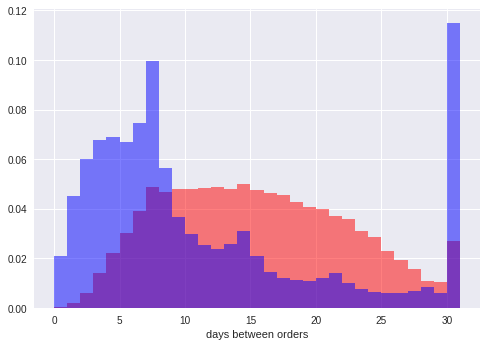

In [8]:
dt = df_ord.groupby('user_id')['days_since_prior_order'].mean().tolist()
dt2 = df_ord['days_since_prior_order'].dropna().tolist()
plt.hist(dt, bins = range(int(min(dt)), int(max(dt))+2), normed = 1, alpha = 0.5, color = 'red')
plt.hist(dt2, bins = range(int(min(dt2)), int(max(dt2)+2)), normed = 1, alpha = 0.5, color = 'blue')
plt.xlabel('days between orders')
plt.show()
del dt, dt2

Red is the distribution of the average number of days between consecutive orders per user, blue is the distribution of the number of days between consecutive orders (no grouping per customer). The blue histogram is particularly interesting, since it has noticeable peaks at 7, 14 and 21 - this seems to indicate that some people prefer to order regularly, often at the same day of the week. Another noticable feature of the plot is the high peak at 30, and no `days_since_prior_order` greater than 30. Although values greater than 30 should exist in practice, it seem that if a values was greater thant 30, it has been cut-off to 30. This explains the high density at 30.

/home/dominik/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


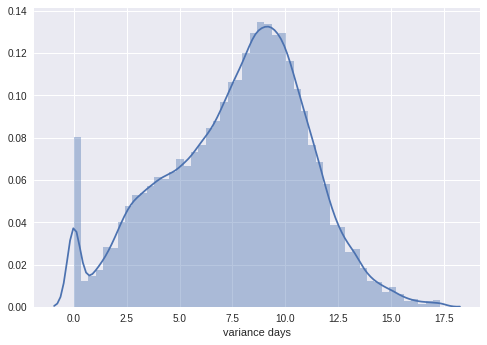

In [9]:
dv = df_ord.groupby('user_id')['days_since_prior_order'].std()
sns.distplot(dv)
plt.xlabel('variance days')
plt.show()
del dv

Generally, users order at quite irregular intervals. The peak at 0 does not necessarily represent 8% of the customers who order extremely regularly. It will most likely get contributions from users who did not place many orders, and from users who wait more than 30 days between orders. The cutoff at 30 will make it look as if orders are very regular.

How often do customers shop at instacart, anyway?

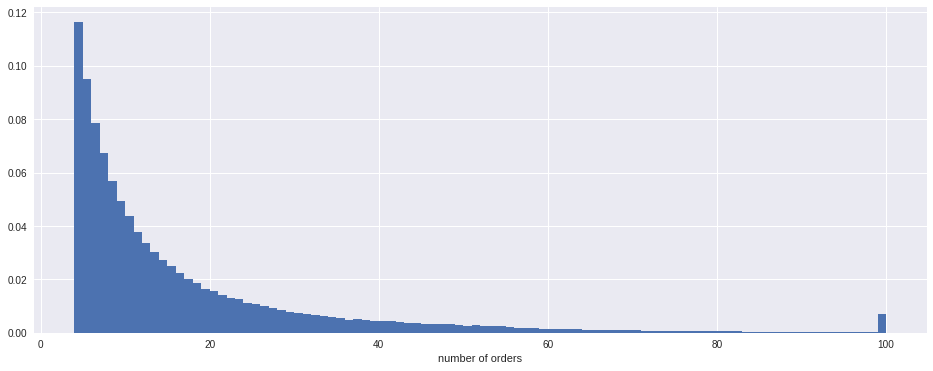

In [10]:
df = df_ord.loc[:, ['user_id', 'order_id']].groupby('user_id').count()
dt = df['order_id'].tolist()
plt.figure(figsize = (16,6))
plt.hist(dt, bins = 96, normed = 1)     #there are 96 bins
plt.xlabel('number of orders')
plt.show()
del df, dt

This is a very smooth distribution. We nortice two things: Customers represented in the dataset placed at least four orders, and if a customer placed more than 100 orders, all excess orders were removed. Therefore we observe a peak at 100.

How many products do customers buy per (prior) order, on average?

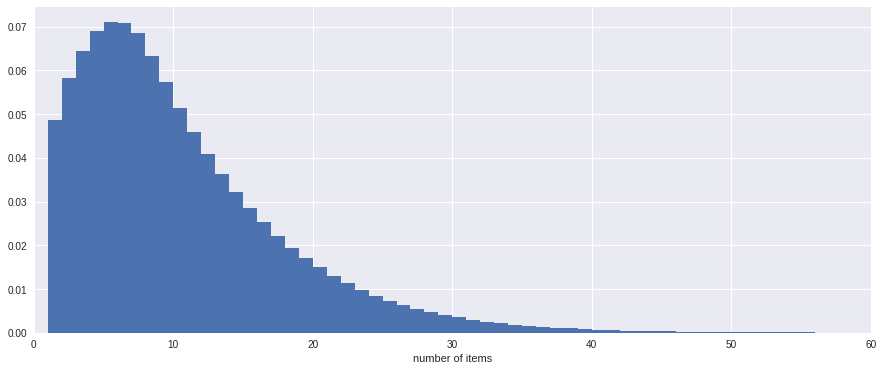

In [11]:
df_0 = df_opp.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
df_0 = df_0['product_id'].tolist()
plt.figure(figsize = (15,6))
plt.hist(df_0, normed = 1, bins = range(min(df_0), max(df_0)+ 2)) 
plt.xlabel('number of items')
plt.xlim(0, 60)
plt.show()
del df_0

When do people order?

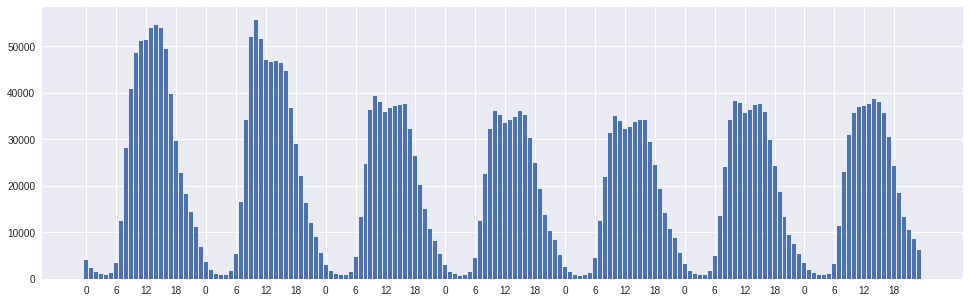

In [12]:
ft = df_ord.groupby(['order_dow', 'order_hour_of_day'])['order_hour_of_day'].count().tolist()
plt.figure(figsize = (16.5,5))
plt.bar(range(24*7), ft)
plt.xticks(range(0,24*7, 6), [str(k%24) for k in range(0,24*7,6)])
plt.show()

Since the data behaves dfferently for `dow` 0 and 1, it is plausible to guess that the encode the weekend. 

We now turn to the products - what are popular products?

In [13]:
product_freq = df_opp.groupby('product_id')['product_id'].count().sort_values(ascending = False)
product_ids = product_freq.index.tolist()
df = df_pro[df_pro['product_id'].isin(product_ids[:15])].copy()
df["abs_freq"] = df["product_id"].map(product_freq.to_dict())
df.sort_values('abs_freq', ascending = False)

,product_id,product_name,aisle_id,department_id,abs_freq
24851,24852,Banana,24,4,472565
13175,13176,Bag of Organic Bananas,24,4,379450
21136,21137,Organic Strawberries,24,4,264683
21902,21903,Organic Baby Spinach,123,4,241921
47208,47209,Organic Hass Avocado,24,4,213584
47765,47766,Organic Avocado,24,4,176815
47625,47626,Large Lemon,24,4,152657
16796,16797,Strawberries,24,4,142951
26208,26209,Limes,24,4,140627
27844,27845,Organic Whole Milk,84,16,137905


Bananas are by far the most popular items! Moreover, organic fruits and vegetables are very popular. The only outlier within the first 15 orders is Whole Milk.

3 Customer-specific Exploration
===

Let's pick a random user, and visualize their behavior:

In [24]:
lo = 0
all_users = set(df_ord['user_id'].tolist())
while lo < 40:   #only pick from users with at least 40 prior orders
    usr = rd.sample(all_users,1)[0]
    # prior order ids of selected user:
    orders = df_ord[(df_ord['user_id'] == usr) & (df_ord['eval_set'] == 'prior')].loc[:, 'order_id'].tolist()
    lo = len(orders)
print('{} orders'.format(len(orders)))
dic_pro = pd.Series(df_pro.product_name.values,index=df_pro.product_id).to_dict()   # dict of product names

48 orders


In [25]:
df = df_opp[df_opp['order_id'].isin(orders)].copy()  # dataframe of prior orders of usr
df['names'] = df['product_id'].map(dic_pro)          # add product names to df
s =df['names'].value_counts()     # display most popular items & rel. freq., with freq > 0.2
print(round(s[s/lo>0.2]/lo,2))
dicto = df['names'].value_counts().to_dict()

Strawberries                                    0.92
Medium Scarlet Raspberries                      0.71
Organic Blackberries                            0.71
Fat Free Skim Milk                              0.67
Banana                                          0.62
Granny Smith Apples                             0.50
Premium Sweet Petites Carrots                   0.48
Cherubs Heavenly Salad Tomatoes                 0.46
Oats & Chocolate Chewy Bars                     0.44
Kids Strawberry Yogurt Tubes                    0.42
Mini Original Babybel Cheese                    0.42
Honeycrisp Apples                               0.42
Brownberry 100% 12 Grain Bread                  0.40
Green Beans                                     0.38
Original Life Cereal                            0.38
Blueberries                                     0.35
Iceberg Lettuce                                 0.33
Strawberry Greek Yogurt Raisins                 0.31
Honey Bunches of Oats Honey Roasted Cereal    

We get a first idea of products a customer likes - we see that some, few products are reordered a lot, while many others are ordered from time to time, but not frequently.

We now add temporal information about each one of the top 10 products for the chosen customer:

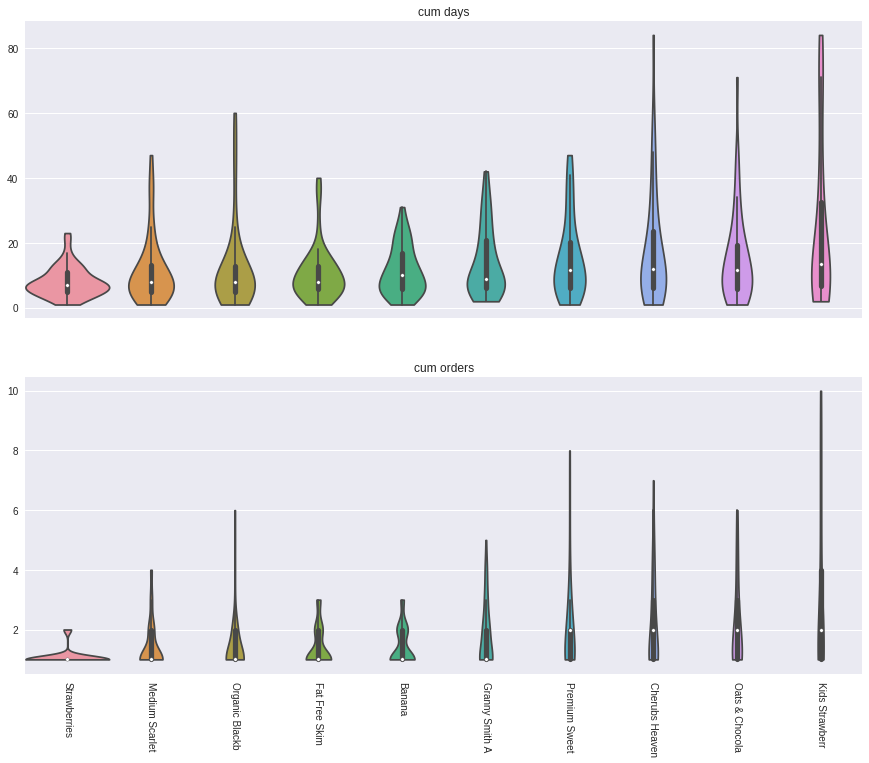

In [26]:
pop_pro_ordered = df['names'].value_counts().index.tolist()   # products, sorted by order frequency
df['pop_prod'] = df['names'].map(lambda x:pop_pro_ordered.index(x))   # add popularity ranking of each product
df_ge_1 = df.groupby("names").filter(lambda x: len(x) > 1).copy()
pop_pro = set(df_ge_1['names'].tolist())     #set of products that were reordered at least twice.
pop_pro = pop_pro & set(pop_pro_ordered[:10])  # 10 most popular products, that were ordered at least 2x
pop_pro = pop_pro_ordered[:len(pop_pro)]   

dic_df = {}
df_orig =  df_ord[df_ord['user_id'] == usr].copy()
for prd in pop_pro:
    # loop through the most popular prod. and store the generated dataframe in dic_df
    ord_ids = df_ge_1.loc[df_ge_1['names'] == prd, 'order_id'].tolist()
    dfo = df_orig.copy()
    dfo['prdct'] = 0
    dfo.loc[dfo['order_id'].isin(ord_ids), 'prdct'] = 1
    dfo['cum_days'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumsum()
    dfo['cum_orders'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumcount()
    dfo['cum_orders']=dfo['cum_orders'].map(lambda x:x+1)

    dic_df[prd] = dfo
# dic_df is a dictionary with product names as keys, and the temporal information df as values.

X = []
Y = []
pp = []
for prd in dic_df:
    dfo = dic_df[prd]
    X.append(dfo.cum_days.tolist())
    Y.append(dfo.cum_orders.tolist())
    pp.append(prd)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 12), sharex=True)
sns.violinplot(data = X, ax = ax1, cut = 0, width = 1)
ax1.set_title('cum days')
sns.violinplot(data=Y, ax = ax2, cut = 0, width = 1)
ax2.set_title('cum orders')

ax2.set_xticklabels([p[:14] for p in pp], rotation =-90)
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

On the x-axis we have listed the 10 most-frequent products for the given user, sorted by frequency. The first plot shows the distribution of days between consecutive orders of the particular product. The second plot show the distriubtion of the number of orders between orders of the given products. 

The correlation between days between consecutive orders of a product and the popularity of the product might not be too surprising. However, we can also see that more popular products are ordered more regularly.

**Understanding temporal variability**

Especially for long-time customers the interest in different products might vary. For short-time customers, however, there is no way of telling this. But for long-term customers, there might be a recognizable trend.

First, we look at the order rate (product orders/total orders). To avoid misleading fluctuation, we group the data into only few time intervals.

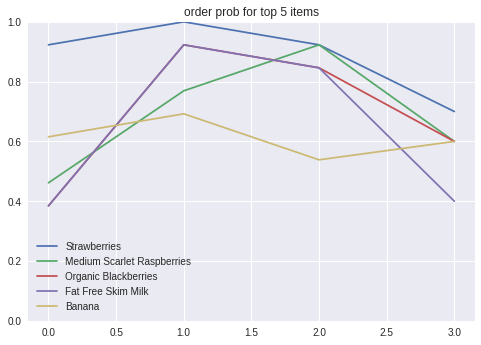

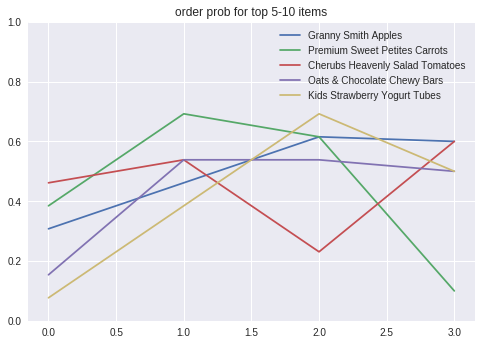

In [29]:
kk = 4  # number of time intervals
for prd in pop_pro[:5]:
    ord_ids = df_ge_1[df_ge_1['names'] == prd].loc[:, 'order_id'].tolist()
    dfo = df_orig.copy()
    dfo['prdct'] = 0
    dfo.loc[dfo['order_id'].isin(ord_ids), 'prdct'] = 1
    dfo['cum_days'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumsum()
    dfo['cum_orders'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumcount()
    dfo['cum_orders']=dfo['cum_orders'].map(lambda x:x+1)
    x = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].mean().tolist()
    plt.plot(x, label = prd)
plt.legend()
plt.ylim(0,1)
plt.title('order prob for top 5 items')
plt.show()

for prd in pop_pro[5:]:
    ord_ids = df_ge_1[df_ge_1['names'] == prd].loc[:, 'order_id'].tolist()
    dfo = df_ord[df_ord['user_id'] == usr].copy()
    dfo['prdct'] = 0
    dfo.loc[dfo['order_id'].isin(ord_ids), 'prdct'] = 1
    dfo['cum_days'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumsum()
    dfo['cum_orders'] = dfo.groupby(dfo.prdct.cumsum().shift().fillna(0)).days_since_prior_order.cumcount()
    dfo['cum_orders']=dfo['cum_orders'].map(lambda x:x+1)
    x = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].mean().tolist()
    plt.plot(x, label = prd)
plt.legend()
plt.ylim(0,1)
plt.title('order prob for top 5-10 items')
plt.show()

Indeed, the order frequency of some products changes over time, and customers change their habits. This is valuable information. However, this data might contain a bias, since we do not know if the order frequency changes as well. Therefore, we look at the average *consumption/day*.

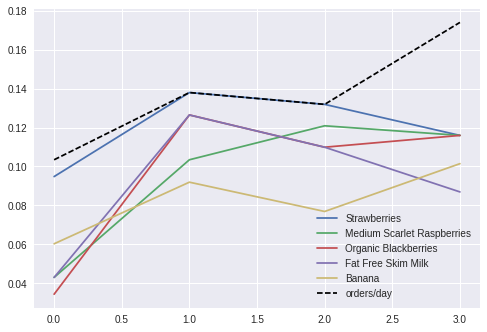

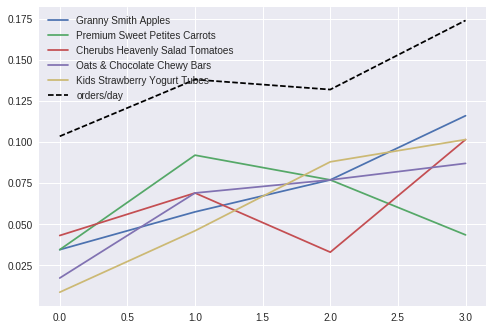

In [30]:
for prd in pop_pro[:5]:
    ord_ids = df_ge_1[df_ge_1['names'] == prd].loc[:, 'order_id'].tolist()
    dfo = df_orig.copy()
    dfo['prdct'] = 0
    dfo.loc[dfo['order_id'].isin(ord_ids), 'prdct'] = 1
    dfo.dropna(axis = 0, inplace = True)
    dft = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].sum() / dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['days_since_prior_order'].sum()
    dfq = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].count() / dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['days_since_prior_order'].sum()
    x = dft.tolist() 
    y = dfq.tolist()
    plt.plot(x, label=prd)
plt.plot(y, color = 'black', linestyle = '--', label = 'orders/day')
plt.legend()
plt.show()

for prd in pop_pro[5:]:
    ord_ids = df_ge_1[df_ge_1['names'] == prd].loc[:, 'order_id'].tolist()
    dfo = df_orig.copy()
    dfo['prdct'] = 0
    dfo.loc[dfo['order_id'].isin(ord_ids), 'prdct'] = 1
    dfo.dropna(axis = 0, inplace = True)
    dft = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].sum() / dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['days_since_prior_order'].sum()
    dfq = dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['prdct'].count() / dfo.groupby(np.arange(len(dfo))//int(np.ceil(len(dfo)/kk)))['days_since_prior_order'].sum()
    x = dft.tolist() 
    y = dfq.tolist()
    plt.plot(x, label=prd)
plt.plot(y, color = 'black', linestyle = '--', label = 'orders/day')
plt.legend()
plt.show()

This is important information: Especially for long-time customers, the favorite products change over time! Often, only roughly the last 10 orders are representative concerning the shopping behavior.